In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
import pandas as pd
import glob
from scipy.stats import poisson
from scipy.stats import multivariate_normal
import pyccl as ccl
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
%load_ext autoreload
%autoreload 2
sys.path.append('../modules')
import abundance as cl_count
import covariance as covar
import mvp_pdf
import edit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

# Binned data

In [16]:
dat_full = edit.load_pickle('/sps/lsst/users/cpayerne/1000xsimulations/analysis/binned_catalogs/20x30_binned_catalogs.pkl')

# Prediction

In [35]:
n_z_bin = 20
n_logm_bin = 30
z_corner = np.linspace(0.2, 1.2, n_z_bin + 1)
logm_corner = np.linspace(14.2, 15.6, n_logm_bin + 1)
Z_bin, logMass_bin = binning(z_corner), binning(logm_corner)

In [36]:
clc = cl_count.ClusterAbundance()
#choose the halo mass function and mass definition
massdef = ccl.halos.massdef.MassDef('vir', 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncDespali16(cosmo, mass_def=massdef)
halobias = ccl.halos.hbias.HaloBiasTinker10(cosmo, mass_def= massdef, mass_def_strict=True)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25) * 4 * np.pi
clc.f_sky = clc.sky_area/(4*np.pi)
z_grid = np.linspace(0., 2.1, 2000)
logm_grid = np.linspace(14.1, 15.7, 2001)
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
Abundance = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')
clc.compute_halo_bias_grid_MZ(z_grid = z_corner, logm_grid = logm_corner, halobiais = halobias)
NHalo_bias = clc.Nhalo_bias_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')

In [37]:
Covariance = covar.Covariance_matrix()
#use PySSC from Lacasa et al.
Sij = Covariance.matter_fluctuation_amplitude_fullsky(Z_bin)

In [38]:
Sample_covariance = Covariance.sample_covariance_full_sky(Z_bin, logMass_bin,  NHalo_bias, Sij)/clc.f_sky

In [39]:
Covariance_prediction = Sample_covariance + np.diag(Abundance.flatten())

In [40]:
mu_list = Abundance.flatten()
var_SSC_list = Sample_covariance.diagonal()
MVP = mvp_pdf.MVP(mu_list, var_SSC_list)
MVP._set_axis(5, mu_list, var_SSC_list)
N_, P_MVP = MVP.p_mvp(mu_list, var_SSC_list)

../modules/mvp_pdf.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  P_MVP = np.array([P_MVP_table[indexes] for indexes in self.split_indexes])


(array([422.,  56.,  34.,  27.,  18.,  13.,  11.,  11.,   5.,   3.]),
 array([   0. ,  135.7,  271.4,  407.1,  542.8,  678.5,  814.2,  949.9,
        1085.6, 1221.3, 1357. ]),
 <a list of 10 Patch objects>)

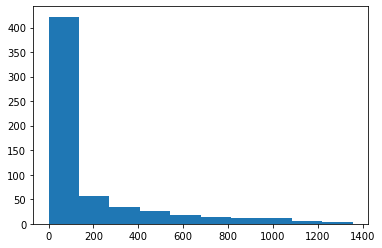

In [41]:
N = np.array(dat_full[3])
N_new = N.reshape(1000,600)
plt.hist(N_new[0].flatten())

In [69]:
mu_list_order = np.sort(mu_list)

In [71]:
mu_list_order.shape

(600,)

[1.9191930796852301, 19.135073183650565, 1273.9775207975213]


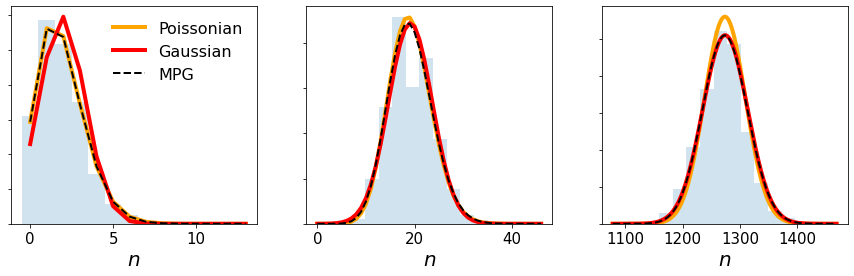

In [125]:
k = 0
intervals = [[1,2],[50, 60],[1200,2000]]
mu_list_plot = [mu_list_order[190], mu_list_order[300], mu_list_order[599]]
print(mu_list_plot)
interval_done = [False, False, False]
bins = [np.arange(10)-.5, np.linspace(1,500,100), np.linspace(intervals[2][0],intervals[2][1],70)]
fig, ax = plt.subplots(1, 3, figsize = (15,4))
plt.subplots_adjust(wspace = .2)
plt.rcParams['axes.axisbelow'] = True
for n, p_mvp, i in zip(N_, P_MVP, np.arange(len(N_))):
    mu = mu_list[i]
    rv = poisson(mu)
    n_sigma = 5
   # mask = (n > mu - n_sigma*np.sqrt((var_SSC_list[i] + mu)))*(n < mu + n_sigma*np.sqrt((var_SSC_list[i] + mu)))
    poisson_ = rv.pmf(n)
    pdf = multivariate_normal.pdf(n, mean=mu, cov=var_SSC_list[i] + mu)
    for s, interval in enumerate(intervals):
        if (mu == mu_list_plot[s])*(interval_done[s] == False):
            interval_done[s] = True
            #ax[s].plot(n[mask], poisson_[mask], '-k', linewidth = 3, label = 'Poissonian')
            #ax[s].plot(n[mask], pdf[mask]/np.sum(pdf), '-g', linewidth = 3, label = 'Gaussian')
            #ax[s].plot(n[mask], p_mvp[mask], '--r', linewidth = 3, label = 'MVP')
            ax[s].plot(n, poisson_, 'orange', linewidth = 4, label = 'Poissonian')
            ax[s].plot(n, pdf/np.sum(pdf), '-r', linewidth = 4, label = 'Gaussian')
            ax[s].plot(n, p_mvp, '--k', linewidth = 2, label = 'MPG')
            #mask_bin = (bins[s] > mu - n_sigma*np.sqrt((var_SSC_list[i] + mu)))*(bins[s] < mu + n_sigma*np.sqrt((var_SSC_list[i] + mu)))
            #bins_corrected = bins[s]#[mask_bin]
            bins=None
            if s==0: bins=np.arange(10)-.5
            ax[s].hist(N_new[:,i], density=True, linewidth = 3, align='mid', alpha = .2,bins=bins)
            #a, b = np.histogram(N_new[:,i])
            
            #bin_middle = [(bins_corrected[i] + bins_corrected[i+1])/2 for i in range(len(bins_corrected)-1)]
            #a_normalized = a/(sum(a)*(bins_corrected[1]-bins_corrected[0]))
            #ax[s].plot(bin_middle, a_normalized, label = 'histogram')
            ax[s].set_xlabel(r'$n$', fontsize = 20)
            ax[s].tick_params(axis='both', which = 'major', labelsize= 15)
            if s == 0:
                ax[s].legend(frameon = False, framealpha = 1, fontsize = 16, loc = 'best')
            plt.setp( ax[s].get_yticklabels(), visible=False )
#plt.savefig('Pinocchio_hist.pdf', bbox_inches='tight', dpi=300)

In [13]:
#where_cat = '/sps/lsst/users/cpayerne/1000xsimulations/1000_simulations/afumagalli/catalogs/plc_14/*'
#cat = glob.glob(where_cat)
#data_Fumagalli = []
#for i,c in enumerate(cat):
#    if i>1000: break
#    cat_test = pd.read_csv(c ,sep=' ',skiprows=12, names=['M','z','dec','ra'])
#    ra, dec, redshift, Mvir = cat_test['ra'], cat_test['dec'], cat_test['z'], cat_test['M']/0.677
#    Ns, mass_edges, z_edges, im  = plt.hist2d(np.log10(Mvir),redshift, 
#                                       bins=[logm_corner,z_corner], cmin=0)
#    data_Fumagalli.append(Ns.T.flatten())